# 0.0 TOOLS 

## 0.1 Imports 

In [62]:
import os
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import matplotlib.pyplot   as plt

from scipy                 import stats
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

## 0.2. Loading Data 

### 0.2.1. Load Data From CSV File

In [10]:
data = pd.read_csv('/home/felipe/repos/insurance_cross_sell/data/train.csv')

### 0.2.2. Load Data From DataBase

In [11]:
# database credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = ''
# password = ''

In [12]:
# # creat connection with psycopg2
# conn = pg.connect(user = username,
#                   password = password,
#                   host = host,
#                   port = port,
#                   database=database)

In [13]:
# # check schemas in the database
# query_schema = """
#     SELECT nspname
#     FROM pg_catalog.pg_namespace
# """
# schemas = pd.read_sql(query_schema, conn)
# schemas

In [14]:
# # check tables in pa004 schema
# query_tables = """
#     SELECT tablename
#     FROM pg_tables
#     WHERE schemaname = 'pa004'
# """
# tables = pd.read_sql(query_tables, conn)
# tables

In [15]:
# # query tables, merge date and create dataframe
# query_data_raw = """
#     SELECT *
#     FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
#                        LEFT JOIN pa004.insurance i ON (u.id = i.id)
# """
# data_raw = pd.read_sql(query_data_raw, conn)
# conn.close()
# data_raw.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id_01', 'driving_license', 
#                     'vehicle_age', 'vehicle_damage', 'id_02','previously_insured', 'annual_premium', 'vintage', 
#                     'response']
# data = data_raw.drop(data_raw.columns[[5,9]], axis=1)
# data = data.sort_values(by='id', ascending=True)

## 0.3. Helper Functions

In [60]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [17]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

## 1.1. Copy Data Frame 

In [18]:
df1 = data.copy()

In [19]:
#rename columns
df1.columns = map(str.lower, df1.columns)

## 1.2. Data Dimensions

In [20]:
# data dimenstions
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3. Data Dtypes 

In [21]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [22]:
df1['region_code'] = df1['region_code'].astype('int')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int')

## 1.4. Check NAs

In [23]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [24]:
df1.duplicated(['id']).sum()

0

## 1.5. Descriptive Statistics

In [25]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [26]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage',
                     'policy_sales_channel']]
target_attributes = df1['response']

### 1.5.1. Numerical Attributes

In [27]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

In [28]:
# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [29]:
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [30]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


### 1.5.2. Categorical Attributes

In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

# 2. FEATURE ENGINEERING

## 2.0. Copy Data Frame

In [32]:
df2 = df1.copy()

## 2.1. Making Hypotesis

**1.** Male customers have more damaged vehicles

**2.** Male customers are more interested in buy vehicle insurance

**3.** Customers that pay less annual premium are more interested in buy vehicle insurance

**4.** Long time period customers are more insterested in buy vehicle insurance

**5.** Customers older than 36 are more interested in buy vehicle insurance

**6.** Customers with damaged vehicles are more interested in buy vehicle insurance

**7.** Customars with newer vehicles are more interested in buy vehicle insurance

**8.** Customers without driver license have no interest in buy vehicle insurance

**9.** Customers region code have no influence in the interest they have in buying vehicle insurance

**10.** Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance

## 2.2. Feature Engineering

In [33]:
df2['gender'] = df2['gender'].apply(lambda x: 'm' if x=='Male' else 'f')
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x=='> 2 Years' else
                                                        '1_to_2_years' if x== '1-2 Year' else
                                                        'below_1_year')
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

# 3. DATA FILTERING

## 3.0. Copy Data Frame

In [34]:
df3 = df2.copy()

## 3.1. Create Auxiliary DataFrames for Target Variable

In [35]:
no_buy = df3[df3['response'] == 0]
buy = df3[df3['response'] == 1]

# 4. EXPLORATORY DATA ANALYSIS

## 4.0. Copy Data Frame

In [36]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

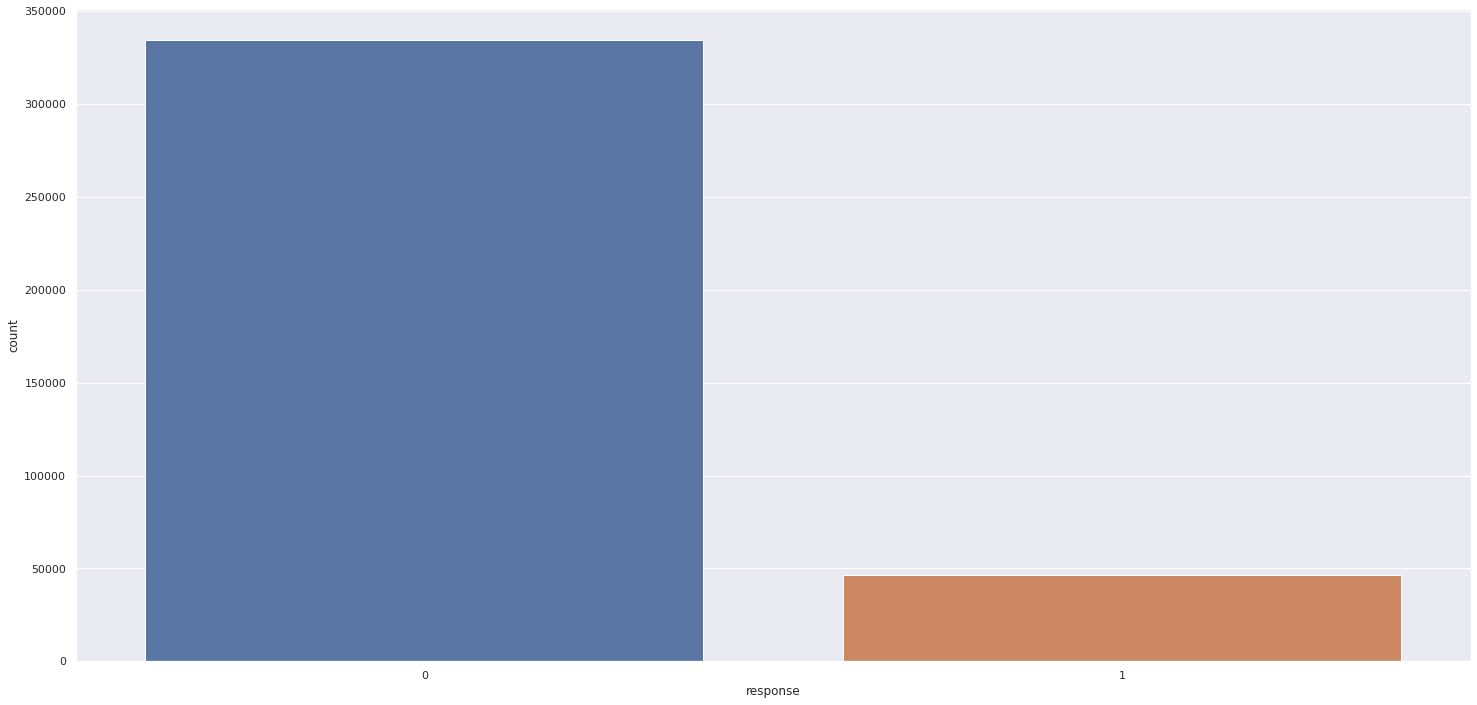

In [37]:
sns.countplot(x='response', data=df1);

### 4.1.2. Numerical Variables

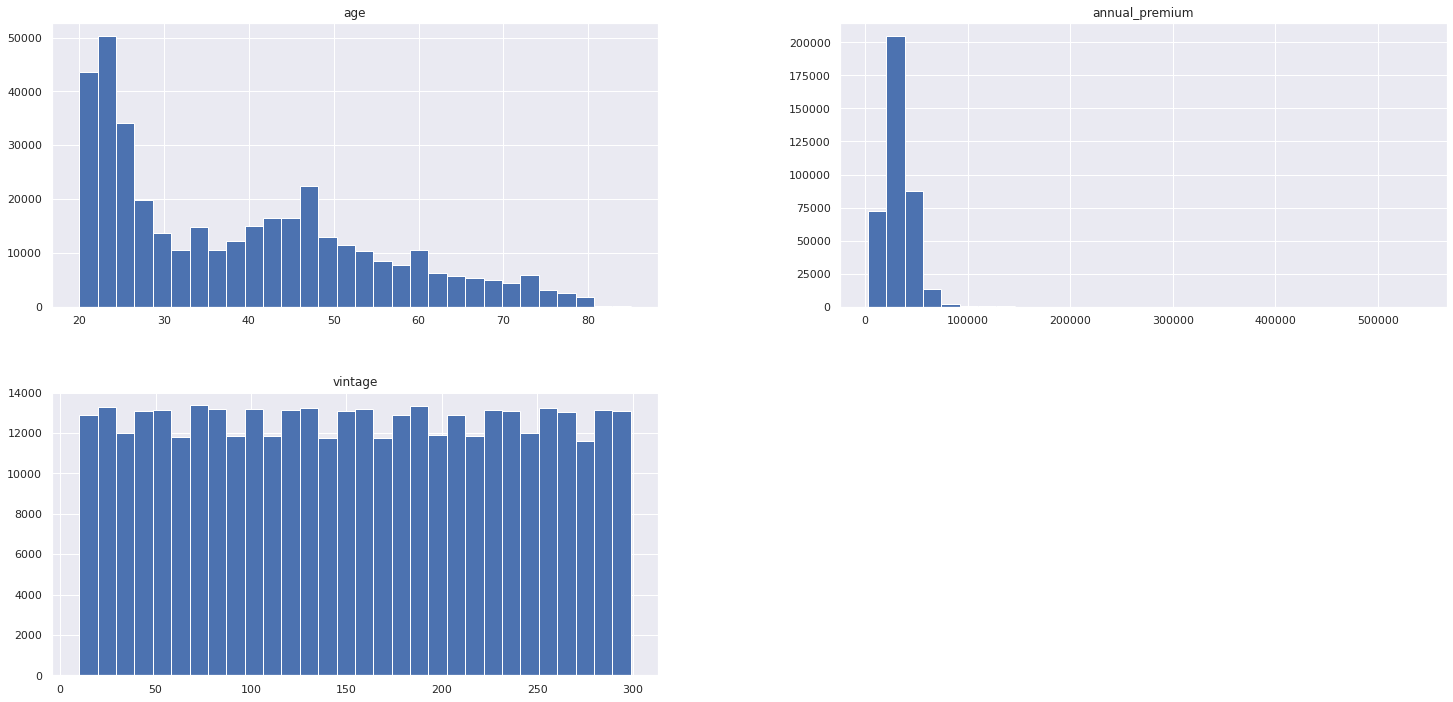

In [38]:
num_attributes.hist(bins=30);

### 4.1.3. Categorical Variables

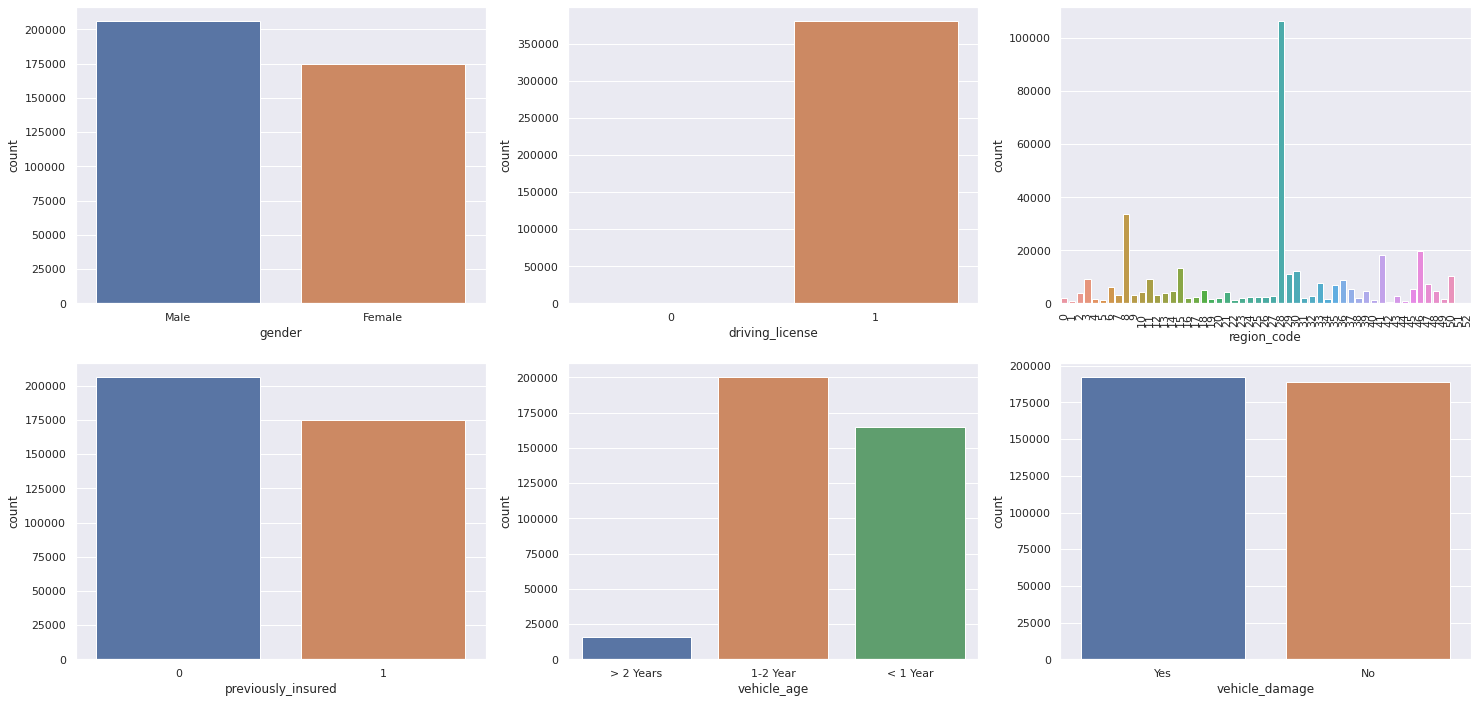

In [39]:
plt.subplot(2,3,1)
sns.countplot(x='gender', data=cat_attributes);

plt.subplot(2,3,2)
sns.countplot(x='driving_license', data=cat_attributes);

plt.subplot(2,3,3)
sns.countplot(x='region_code', data=cat_attributes);
plt.xticks(rotation=90)

plt.subplot(2,3,4)
sns.countplot(x='previously_insured', data=cat_attributes);

plt.subplot(2,3,5)
sns.countplot(x='vehicle_age', data=cat_attributes);

plt.subplot(2,3,6)
sns.countplot(x='vehicle_damage', data=cat_attributes);

## 4.2. Bivariate Analysis

### **1.** Male customers have more damaged vehicles 
**True** 55% m vs 46% f

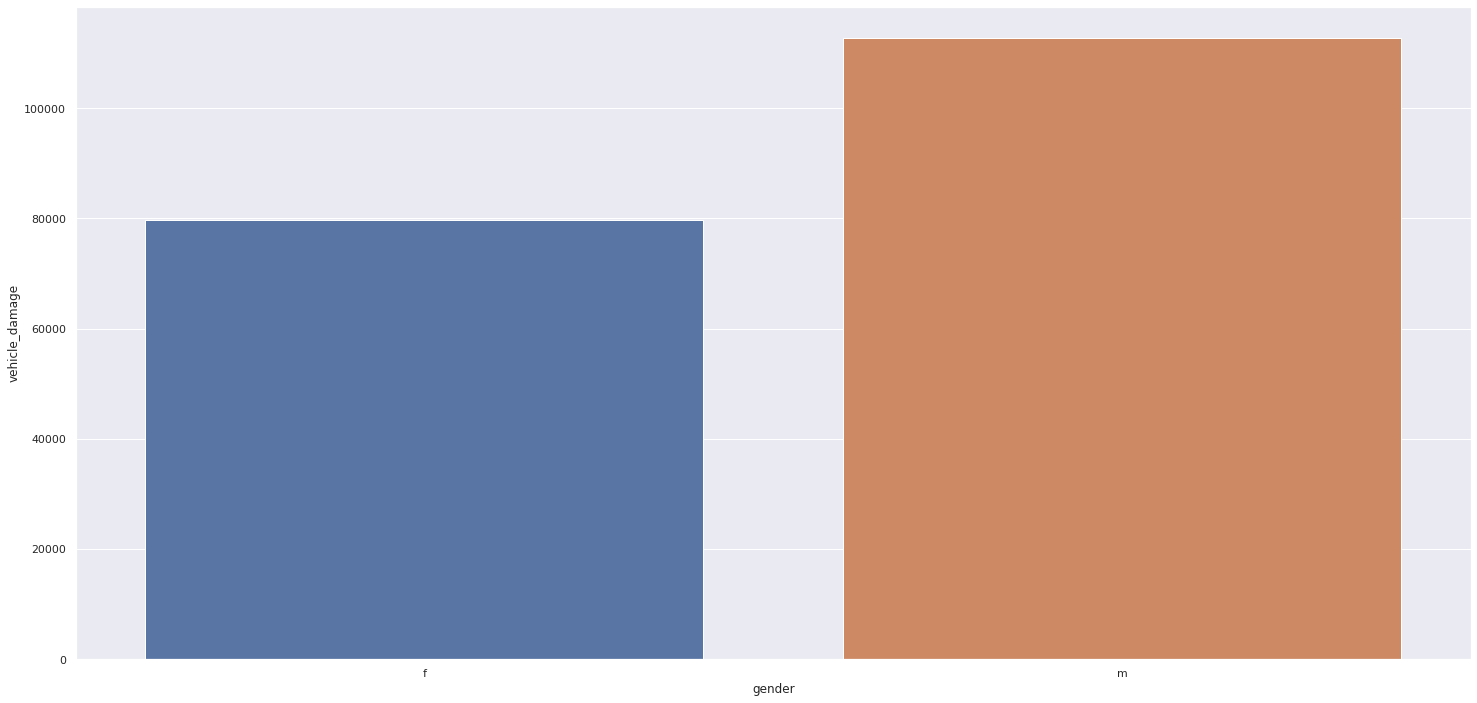

In [40]:
h1 = df4[['gender', 'vehicle_damage']].groupby('gender').sum().reset_index()
sns.barplot(x='gender', y='vehicle_damage', data=h1);

In [41]:
aux_h1 = pd.crosstab(df4['gender'], df4['vehicle_damage'])
aux_h1['percentage'] = aux_h1[1]/(aux_h1[1]+aux_h1[0])
aux_h1

vehicle_damage,0,1,percentage
gender,,,
f,95355,79665,0.455177
m,93341,112748,0.547084


### **2.** Male customers are more interested in buy vehicle insurance
**True** 14% m vs 10% f

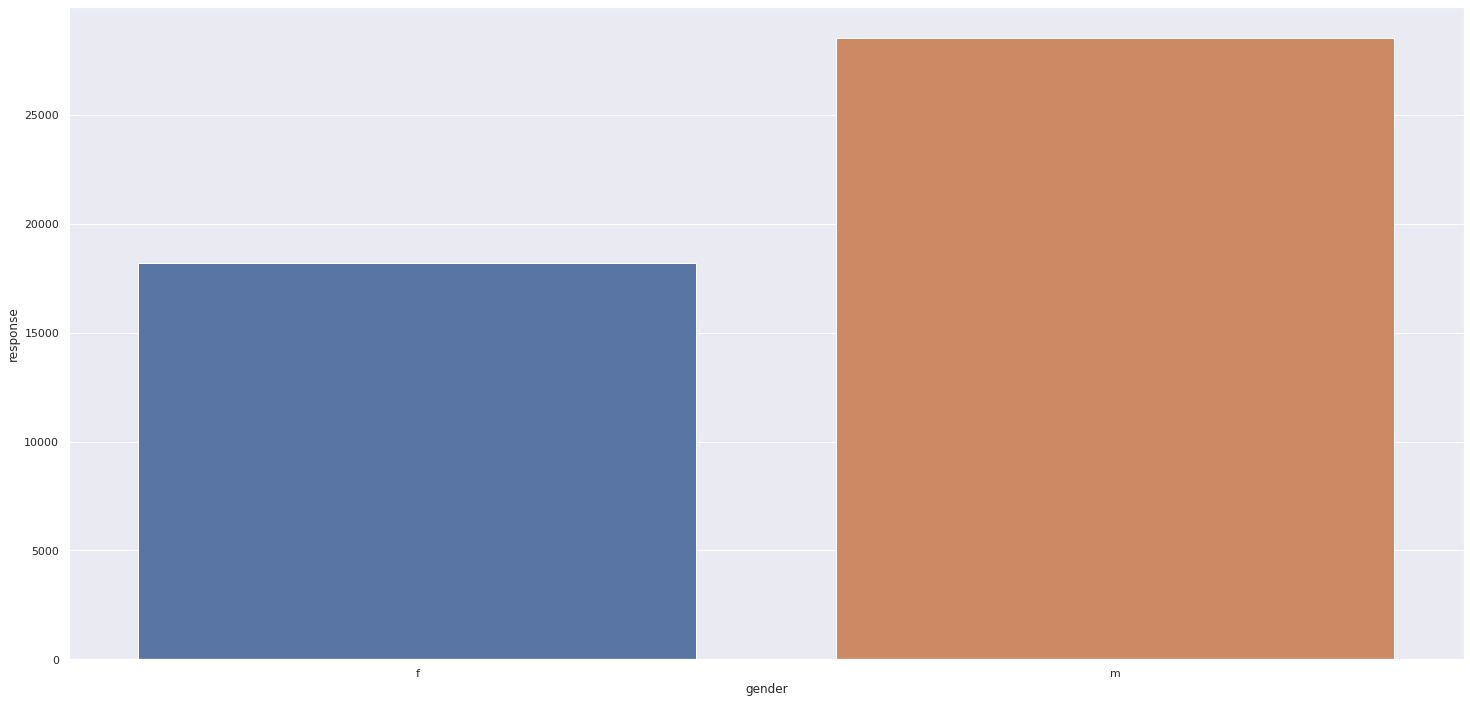

In [42]:
h2 = df4[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot(x='gender', y='response', data=h2);

In [43]:
aux_h2 = pd.crosstab(df4['gender'], df4['response'])
aux_h2['percentage'] = aux_h2[1]/(aux_h2[1]+aux_h2[0])
aux_h2

response,0,1,percentage
gender,,,
f,156835,18185,0.103902
m,177564,28525,0.138411


### **3.** Customers that pay less annual premium are more interested in buy vehicle insurance
**False** - There are no significant difference

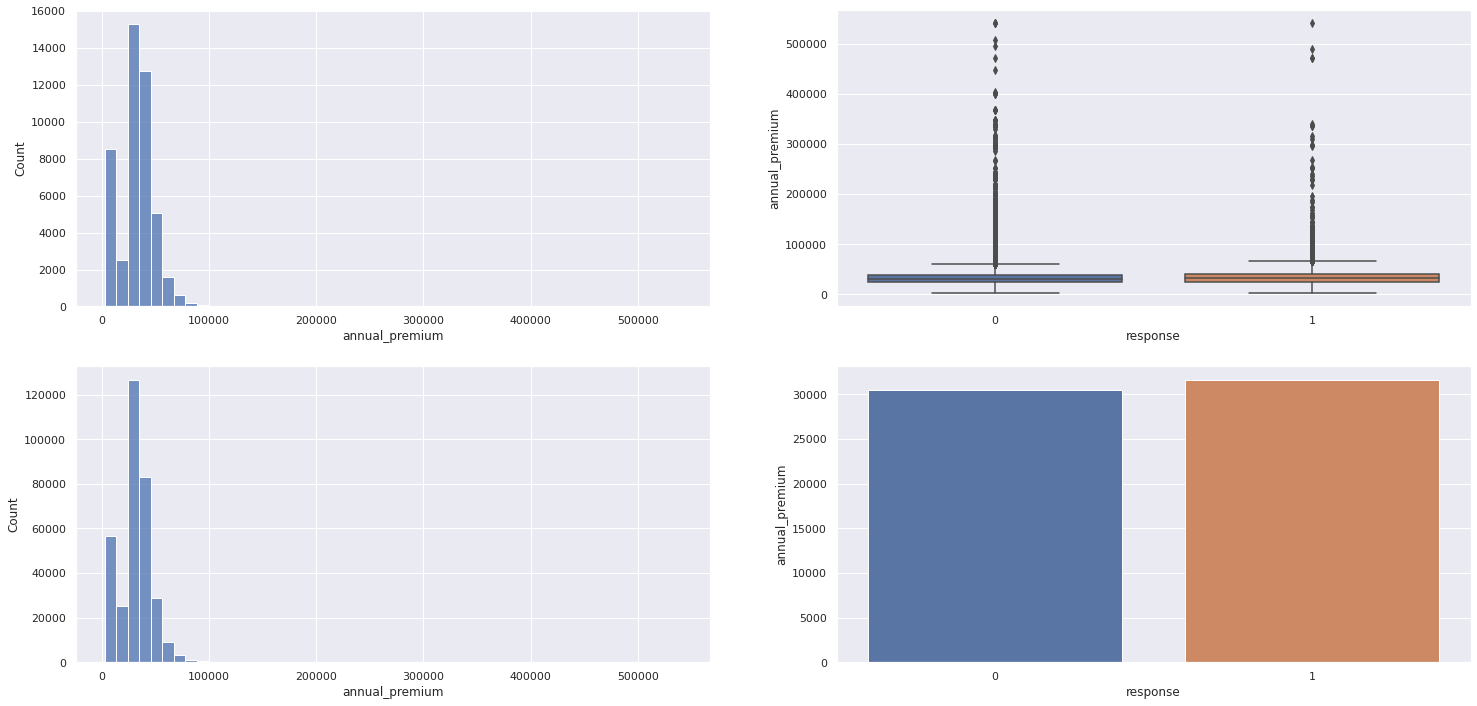

In [44]:
plt.subplot(2,2,1)
sns.histplot(x='annual_premium', bins=50, data=buy);

plt.subplot(2,2,3)
sns.histplot(x='annual_premium', bins=50, data=no_buy);

plt.subplot(2,2,2)
sns.boxplot(x='response', y='annual_premium', data=df4);

h3 = df4[['response', 'annual_premium']].groupby('response').mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='response', y='annual_premium', data=h3);

### **4.** Long time period customers are more insterested in buy vehicle insurance
**False** - There are no significant difference

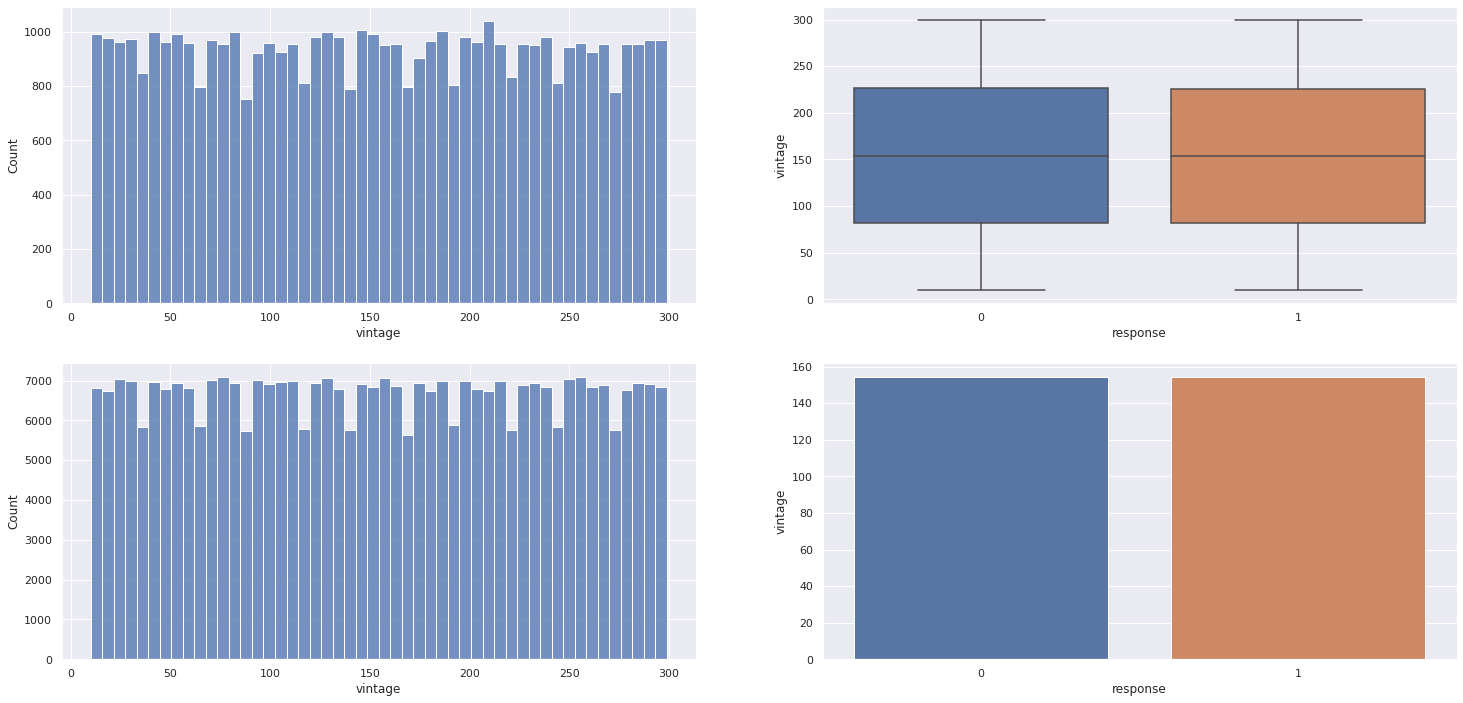

In [45]:
plt.subplot(2,2,1)
sns.histplot(x='vintage', bins=50, data=buy);

plt.subplot(2,2,3)
sns.histplot(x='vintage', bins=50, data=no_buy);

plt.subplot(2,2,2)
sns.boxplot(x='response', y='vintage', data=df4);

h4 = df4[['response', 'vintage']].groupby('response').mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='response', y='vintage', data=h4);

### **5.** Customers older than 36 are more interested in buy vehicle insurance
**True** 18% over 36 customer vs 7% under 36 customers

In [46]:
aux1 = df4[['age', 'response']].groupby('response').mean().reset_index()
aux1

,response,age
0,0,38.178227
1,1,43.435560


In [47]:
aux2 = df4.copy()
aux2['age_test'] = aux2['age'].apply(lambda x: 'over_36' if x>36 else 'under_36')

aux3 = pd.crosstab(aux2['age_test'], aux2['response'])
aux3['percentage'] = aux3[1]/(aux3[1]+aux3[0])
aux3

response,0,1,percentage
age_test,,,
over_36,155918,33313,0.176044
under_36,178481,13397,0.069820


### **6.** Customers with damaged vehicles are more interested in buy vehicle insurance
**True** 24% of customers with damaged vehicle are interested vs 0.5% of customers whitout damage

In [48]:
h6_1 = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()
h6_2 = df4[['id', 'vehicle_damage']].groupby('vehicle_damage').count().reset_index()
h6_3 = pd.merge(h6_1, h6_2, on='vehicle_damage', how='left')
h6_3['percentage'] = h6_3['response']/h6_3['id']
h6_3

,vehicle_damage,response,id,percentage
0,0,982,188696,0.005204
1,1,45728,192413,0.237655


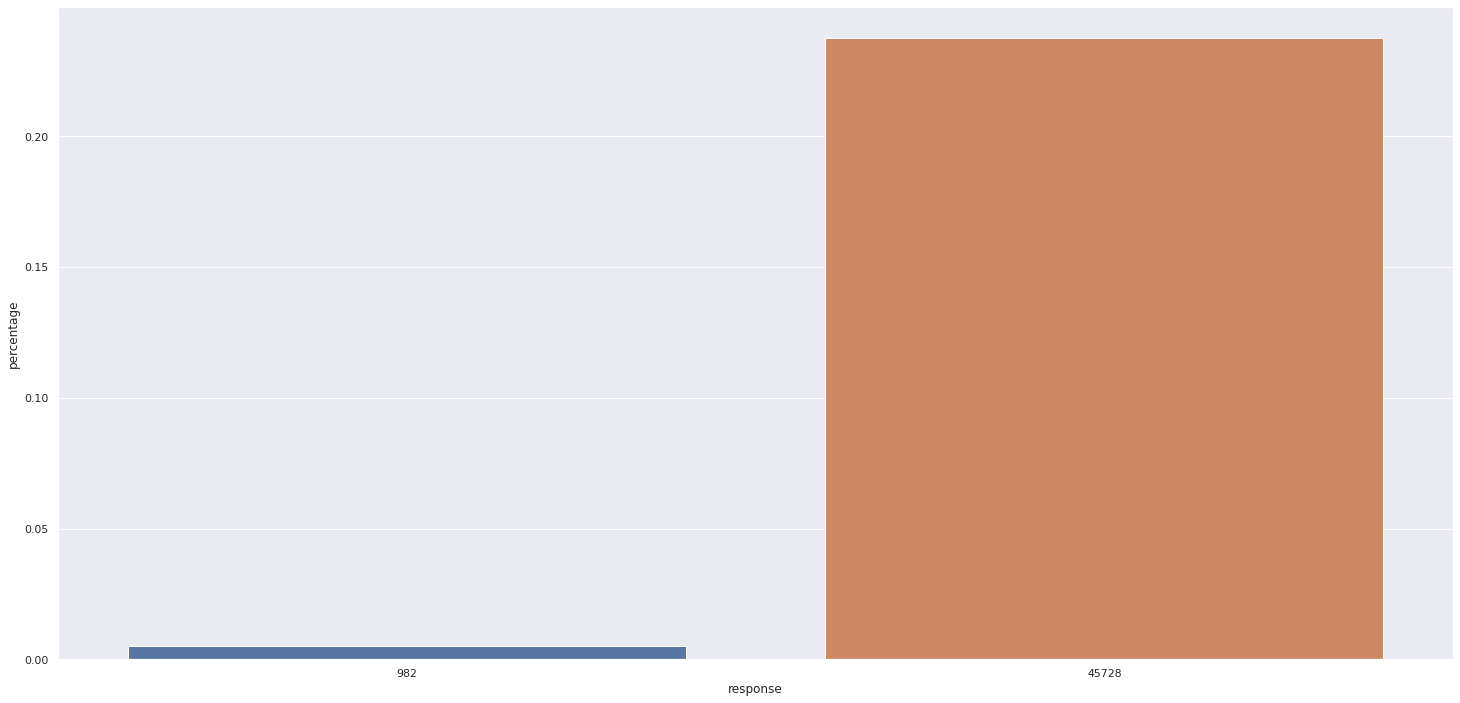

In [49]:
sns.barplot(x='response', y='percentage', data=h6_3);

### **7.** Customers with newer vehicles are more interested in buy vehicle insurance
**True** 29% of customers with vechicles older than 2 years are interested vs 17% 1 to 2 year vs 4% under 1 year. PS: number of customers with vehicles within 1 to 2 years old is much greater

In [50]:
h7_1 = df4[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
h7_2 = df4[['vehicle_age', 'id']].groupby('vehicle_age').count().reset_index()
h7_3 = pd.merge(h7_1, h7_2, on='vehicle_age', how='left')
h7_3['percentage'] = h7_3['response']/h7_3['id']
h7_3

,vehicle_age,response,id,percentage
0,1_to_2_years,34806,200316,0.173755
1,below_1_year,7202,164786,0.043705
2,over_2_years,4702,16007,0.293746


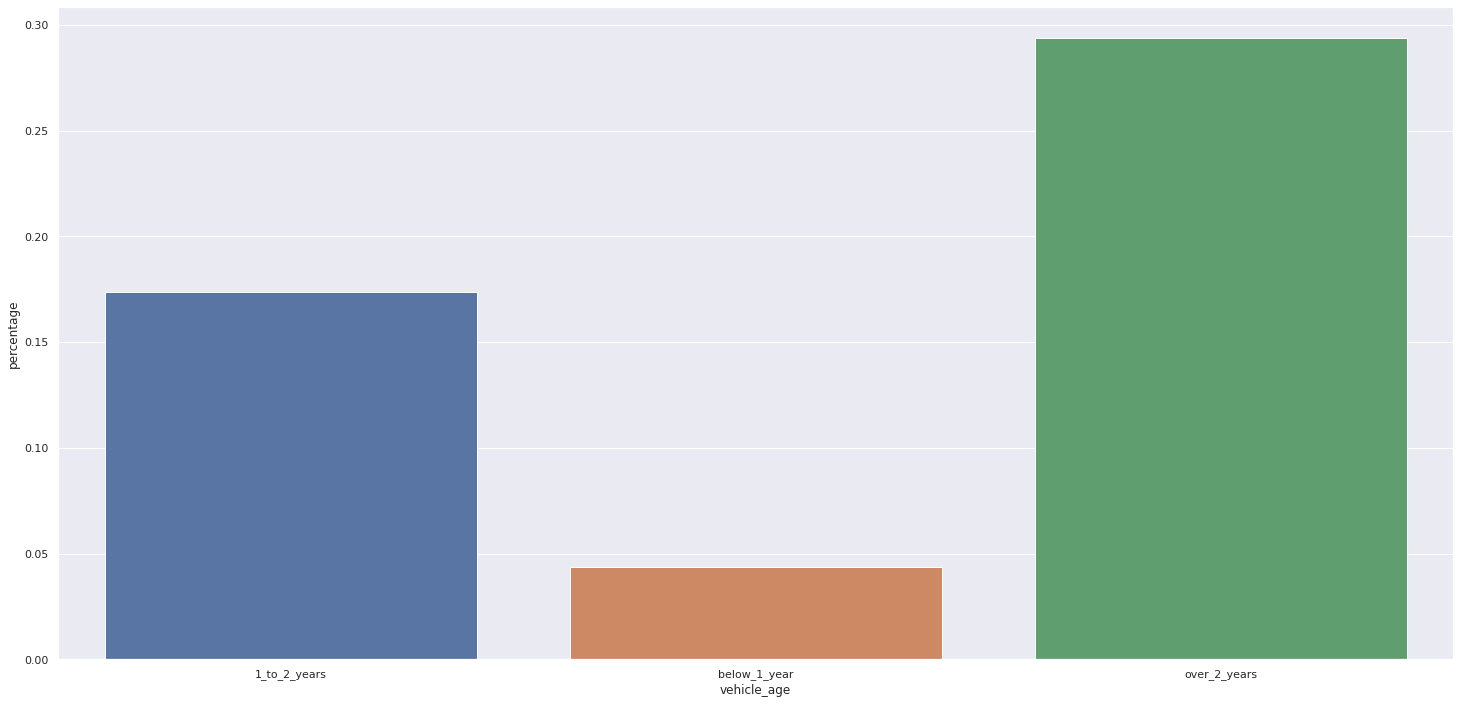

In [51]:
sns.barplot(x='vehicle_age', y='percentage', data=h7_3);

### **8.** Customers without driver license have less interest in buy vehicle insurance
**True** - 5% of customers without license are interested vs 12% of customers with license

In [52]:
h4 = pd.crosstab(df4['driving_license'], df4['response'])
h4['percentage'] = h4[1]/(h4[1]+h4[0])
h4

response,0,1,percentage
driving_license,,,
0,771,41,0.050493
1,333628,46669,0.122717


### **9.** Customers region code have no influence in the interest they have in buying vehicle insurance
**False** - There is influence

In [53]:
h9_1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
h9_2 = df4[['region_code', 'id']].groupby('region_code').count().reset_index()
h9_3 = pd.merge(h9_1, h9_2, on='region_code', how='left')
h9_3['percentage'] = h9_3['response']/h9_3['id']
h9_3.sort_values(by='percentage', ascending=False).head()

,region_code,response,id,percentage
38,38,389,2026,0.192004
28,28,19917,106415,0.187163
19,19,250,1535,0.162866
4,4,285,1801,0.158245
23,23,300,1960,0.153061


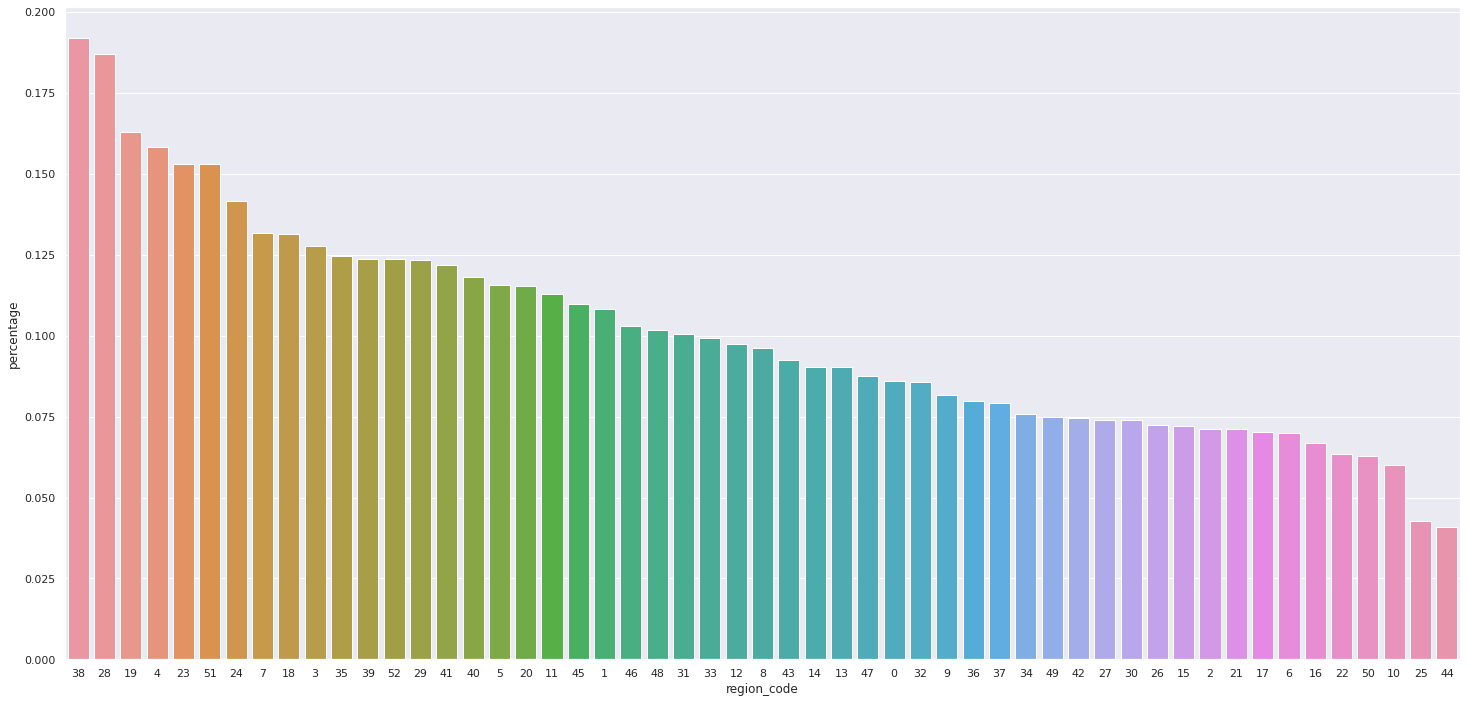

In [54]:
sns.barplot(x='region_code', y='percentage', data=h9_3, order=h9_3.sort_values('percentage', ascending=False).region_code);

### **10.** Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance
**False** - There is influence

In [55]:
h10_1 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
h10_2 = df4[['policy_sales_channel', 'id']].groupby('policy_sales_channel').count().reset_index()
h10_3 = pd.merge(h10_1, h10_2, on='policy_sales_channel', how='left')
h10_3['percentage'] = h10_3['response']/h10_3['id']
h10_3.sort_values(by='percentage', ascending=False).head()

,policy_sales_channel,response,id,percentage
118,123,1,1,1.000000
41,43,1,1,1.000000
25,27,1,3,0.333333
26,28,1,3,0.333333
34,36,17,52,0.326923


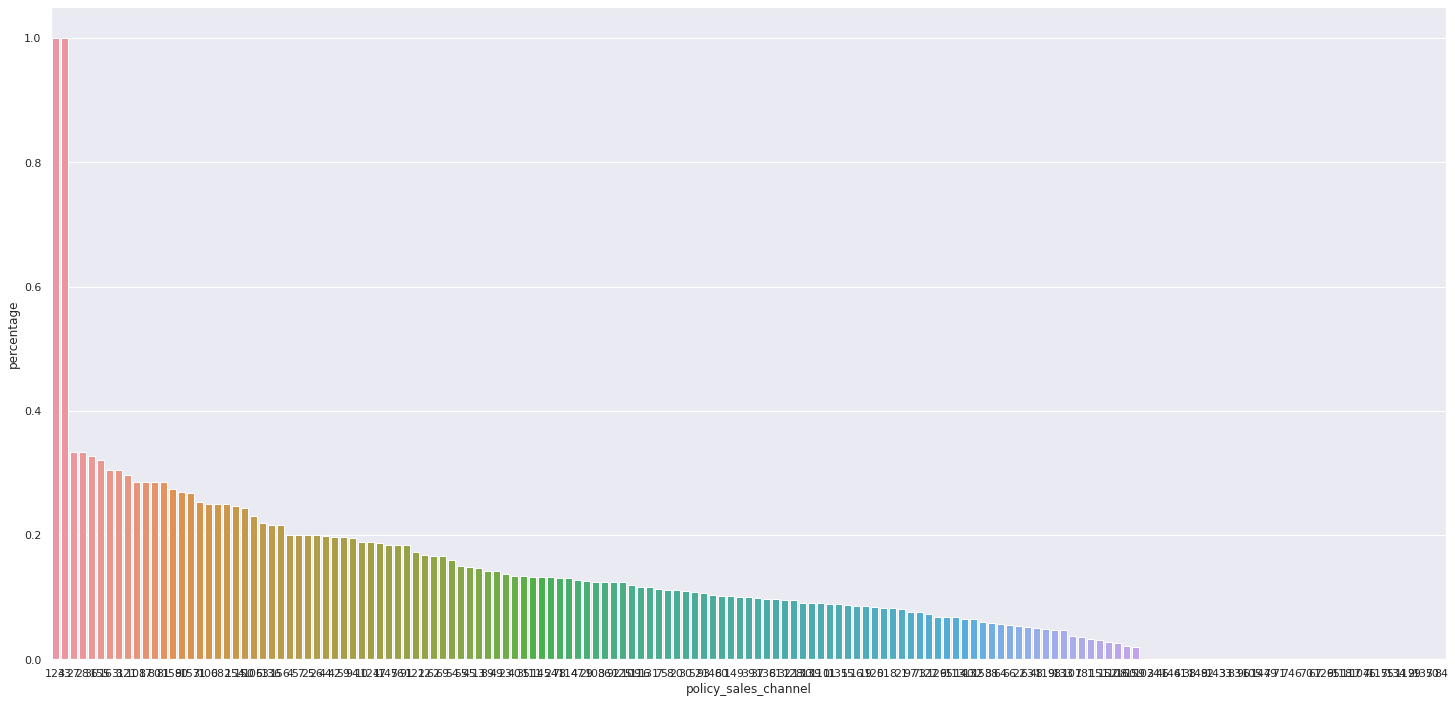

In [56]:
sns.barplot(x='policy_sales_channel', y='percentage', data=h10_3, order=h10_3.sort_values('percentage', ascending=False).policy_sales_channel);

### 4.2.1. Summary of Hypotesis

In [57]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'Medium'],
       ['H2', 'True', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Medium'],
       ['H5', 'True', 'High'],
       ['H6', 'True', 'High'],
       ['H7', 'True', 'Medium'],
       ['H8', 'True', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'Medium']]
print(tabulate(tab, headers='firstrow'))


Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           True          Medium
H2           True          Medium
H3           False         Medium
H4           False         Medium
H5           True          High
H6           True          High
H7           True          Medium
H8           True          High
H9           False         High
H10          False         Medium


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

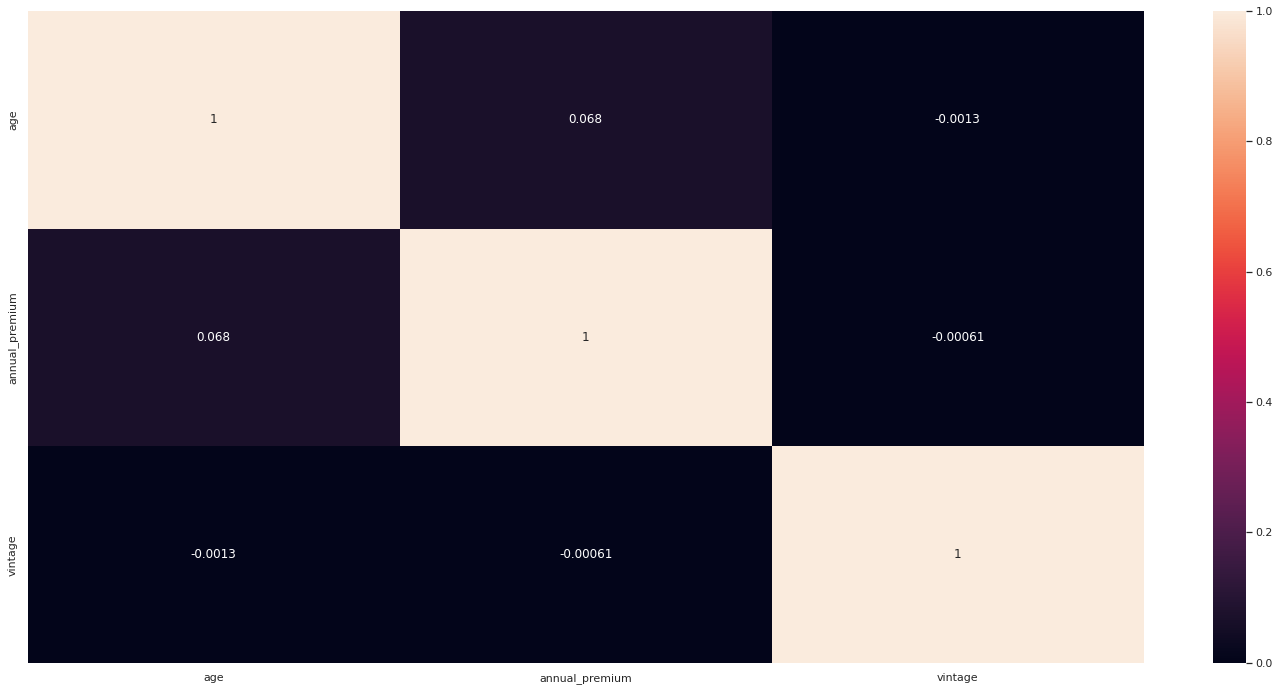

In [58]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

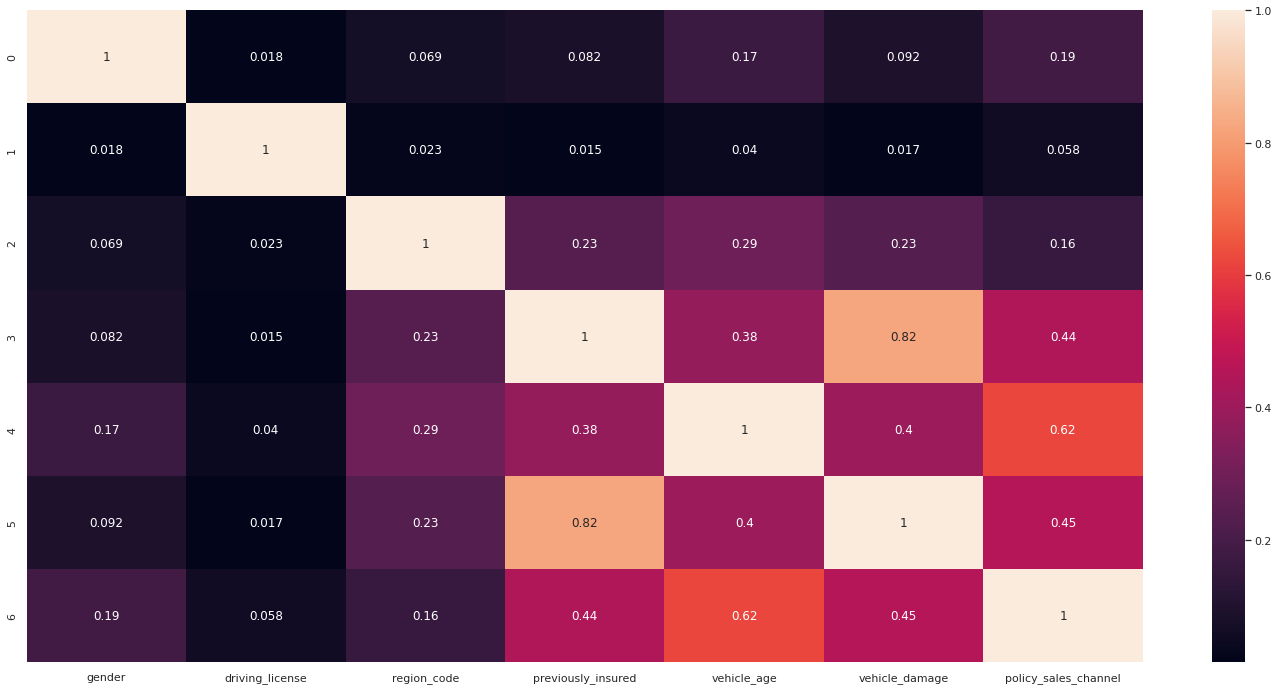

In [63]:
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5. DATA PREPARATION